# Montreal Mural Classifier

The intention for this project is to build a web app that can take any picture of a mural in Montreal and tell you who did it.

Initially, it will only be able to recognize murals done for Mural Festival. But the plan is to build on top of that to include other murals and even tags if I can get the model to recognize them.

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *

In [2]:
train_path = Path('train')
valid_path = Path('valid')
path = Path('Data')

This bit is to correct the orientation on some of my pictures. I'm operating under the assumption that most people will be taking pictures of the murals right side up.

In [21]:
from PIL import Image, ExifTags

artists = (path/train_path).ls()

for a in artists:
    pics = a.ls()
    
    for pic in pics:
        im = Image.open(pic)
        exif = dict(im._getexif().items())

        if exif[orientation] == 6:
            im = im.rotate(270, expand=True)  
            im.save(pic)

First we need to build our databunch from a collection of images. I admit I didn't take all of the pictures myself... I needed a variety of pictures with assorted lighting and surroundings. But I do intend on replacing the pictures I stole with my own once I've collected a good enough training set. I just really wanted to prove the concept first.

In [3]:
np.random.seed(42)
res = 448
bs=8
data = (ImageList
        .from_folder(path=path)
        .split_by_folder()
        .label_from_folder()
        .transform(get_transforms(do_flip=False), size=(res, res))
        .databunch(num_workers=4, bs=bs)).normalize(imagenet_stats)

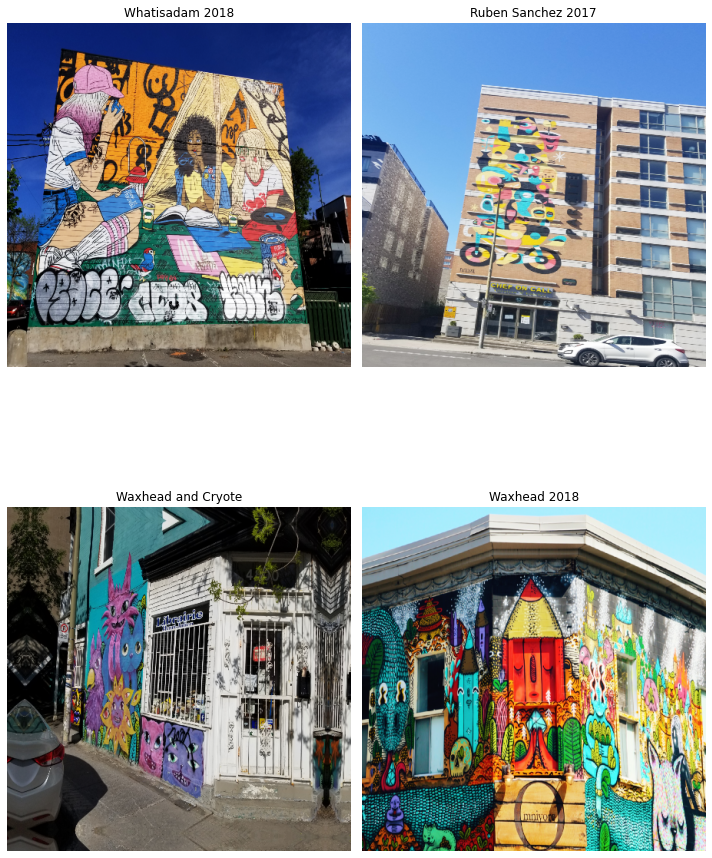

In [4]:
data.show_batch(rows=2, figsize=(10, 15))

In [5]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

One interesting thing I learned from the fastai courses is the concept of progressive resizing. The idea is to train your model on progressively larger images, so it learns to generalize better instead of overfitting. It also works really well to reverse overfitting and speed up the whole learning process in general. 

So here I'm loading a saved state from a model I trained on (336, 336) images. But I'm training it on (448, 448) images. 

In [6]:
learn.load(f'stage-3-{336}-rn34')

Learner(data=ImageDataBunch;

Train: LabelList (559 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Kevin Ledo 2014,Kevin Ledo 2014,Kevin Ledo 2014,Kevin Ledo 2014,Kevin Ledo 2014
Path: Data;

Valid: LabelList (187 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Kevin Ledo 2014,Kevin Ledo 2014,Kevin Ledo 2014,Whatisadam 2018,Whatisadam 2018
Path: Data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [7]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.824662,0.678694,0.106952,03:09
1,0.777556,0.353237,0.101604,03:05


In [9]:
learn.save(f'stage-1-{res}-rn34')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


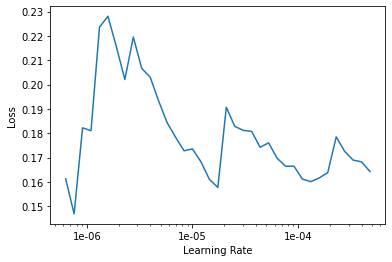

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.036794,0.102282,0.021390,04:07


The model does pretty well so far, but there are still some images it gets confused on. We can see which images have the highest loss with the fastai ClassificationInterpretation, which is really useful for figuring out which murals need more training data.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

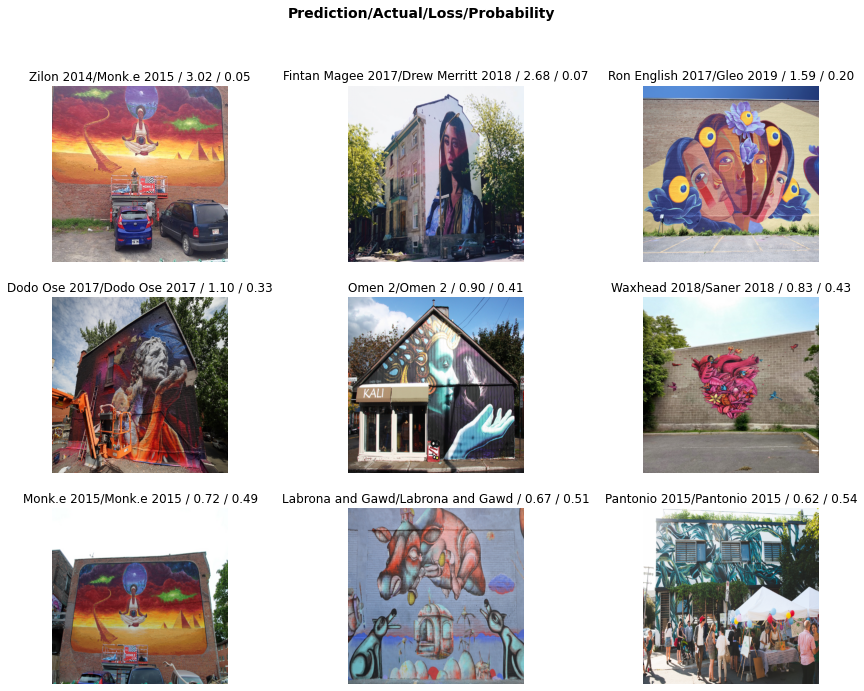

In [22]:
interp.plot_top_losses(9, figsize=(15, 11))

Only 3 wrong! But this could still definitely be improved. Most of the murals only have my pictures as training data, and they are all quit similar since they were taken on the same day in similar areas. I'm sure I could get the model to 100% accuracy and minimal loss as I add images to the training set. 

The next step will be to create an app that can utilize this model to tell users information about the mural they're looking at. 